# Neural networks with PyTorch

Deep learning networks tend to be massive with dozens or hundreds of layers, that's where the term "deep" comes from. You can build one of these deep networks using only weight matrices as we did in the previous notebook, but in general it's very cumbersome and difficult to implement. PyTorch has a nice module `nn` that provides a nice way to efficiently build large neural networks.

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [12]:
from torchvision import datasets,transforms

Now we're going to build a larger network that can solve a (formerly) difficult problem, identifying text in an image. Here we'll use the MNIST dataset which consists of greyscale handwritten digits. Each image is 28x28 pixels, you can see a sample below

<img src='assets/mnist.png'>

Our goal is to build a neural network that can take one of these images and predict the digit in the image.

First up, we need to get our dataset. This is provided through the `torchvision` package. The code below will download the MNIST dataset, then create training and test datasets for us. Don't worry too much about the details here, you'll learn more about this later.

In [14]:
#Nomalization of the Tensors Using transforms method

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [15]:
trainset=datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)

Extracting /home/chaithanya/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /home/chaithanya/.pytorch/MNIST_data/MNIST/raw


Extracting /home/chaithanya/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /home/chaithanya/.pytorch/MNIST_data/MNIST/raw


Extracting /home/chaithanya/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/chaithanya/.pytorch/MNIST_data/MNIST/raw


Extracting /home/chaithanya/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/chaithanya/.pytorch/MNIST_data/MNIST/raw
Processing...
Done!


In [17]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [20]:
testset=datasets.MNIST('~/.pytorch/MNIST_data/',download=True,train=False, transform=transform)

In [21]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: /home/chaithanya/.pytorch/MNIST_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [22]:
testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: /home/chaithanya/.pytorch/MNIST_data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [ ]:
#testloader=torch.utils.data.DataLoader(testset,batch_size=)

In [23]:
dataiter=iter(trainloader)

In [25]:
images,labels=dataiter.next()

In [33]:
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


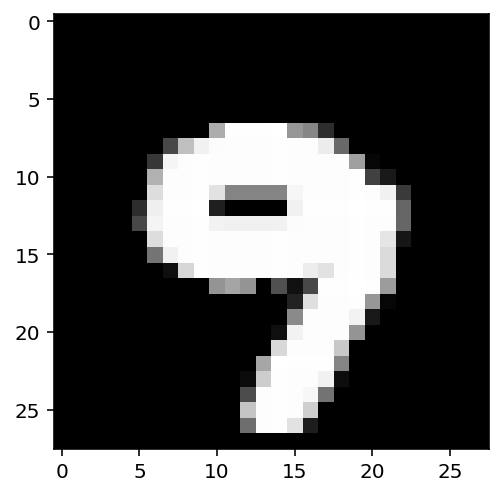

In [39]:
plt.imshow(images[1].numpy().squeeze(),cmap='Greys_r')

In [43]:
labels[1].numpy()

array(9)

First, let's try to build a simple network for this dataset using weight matrices and matrix multiplications. Then, we'll see how to do it using PyTorch's `nn` module which provides a much more convenient and powerful method for defining network architectures.

The networks you've seen so far are called *fully-connected* or *dense* networks. Each unit in one layer is connected to each unit in the next layer. In fully-connected networks, the input to each layer must be a one-dimensional vector (which can be stacked into a 2D tensor as a batch of multiple examples). However, our images are 28x28 2D tensors, so we need to convert them into 1D vectors. Thinking about sizes, we need to convert the batch of images with shape `(64, 1, 28, 28)` to a have a shape of `(64, 784)`, 784 is 28 times 28. This is typically called *flattening*, we flattened the 2D images into 1D vectors.

Previously you built a network with one output unit. Here we need 10 output units, one for each digit. We want our network to predict the digit shown in an image, so what we'll do is calculate probabilities that the image is of any one digit or class. This ends up being a discrete probability distribution over the classes (digits) that tells us the most likely class for the image. That means we need 10 output units for the 10 classes (digits). We'll see how to convert the network output into a probability distribution next.

> **Exercise:** Flatten the batch of images `images`. Then build a multi-layer network with 784 input units, 256 hidden units, and 10 output units using random tensors for the weights and biases. For now, use a sigmoid activation for the hidden layer. Leave the output layer without an activation, we'll add one that gives us a probability distribution next.

In [77]:
Features=images.reshape(64,1*28*28)
# or Images=images.view(images.shape[0],-1)

In [78]:
print(Features)


tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])


In [79]:
print('shape of the Features:',Features.shape)

shape of the Features: torch.Size([64, 784])


In [80]:
n_input_units=Features.shape[1]
n_hidden=256
n_output=10

In [81]:
#weights from input to hidden
w1=torch.randn(n_input_units,n_hidden)
print('shape of w1:',w1.shape)

shape of w1: torch.Size([784, 256])


In [82]:
print(w1)

tensor([[-0.4650,  0.9234, -0.3244,  ..., -1.1531, -0.8091,  0.2477],
        [-0.6958, -1.1015, -0.2318,  ..., -1.1720, -1.0990,  0.4077],
        [-0.1196,  1.4234,  1.0233,  ..., -1.3679, -0.3111,  0.0867],
        ...,
        [-1.3451, -1.6537, -1.5712,  ..., -0.4320, -0.9271,  0.0451],
        [-0.3563,  0.3595, -0.6094,  ..., -0.7485,  0.4664, -0.1086],
        [ 0.4593, -0.0176,  0.1988,  ..., -0.1373,  1.0792, -0.4389]])


In [83]:
#weigths from hidden to output
w2=torch.randn(n_hidden,n_output)
print('shape of w2:',w2.shape)

shape of w2: torch.Size([256, 10])


In [84]:
#bias terms
b1=torch.randn(1,n_hidden)
b2=torch.randn(1,n_output)

In [85]:
b1.shape

torch.Size([1, 256])

In [86]:
b2.shape

torch.Size([1, 10])

In [87]:
input_hidden_w1_b1=torch.matmul(Features,w1)+b1

In [88]:
input_hidden_w1_b1

tensor([[-15.9699, -32.6433, -29.1715,  ...,  34.3492, -72.5384,   6.9633],
        [ -0.1418,  -5.6163, -21.3338,  ...,  19.7449, -18.9479,  -1.5321],
        [-10.0864, -47.0479, -13.0698,  ...,  11.7507, -30.9151, -25.8583],
        ...,
        [-17.2223, -33.1028,  -4.9061,  ...,  13.3564, -52.8842, -33.7956],
        [ 14.1053, -23.2188, -38.1592,  ...,  34.5203, -42.4266,  27.2005],
        [-22.8647, -45.4939,  -3.9718,  ...,  10.2623,  -8.6842, -20.6746]])

In [89]:
input_hidden_w1_b1.shape

torch.Size([64, 256])

In [90]:
def activation(x):
    a=1+torch.exp(-x)
    b=1/a
    return b

In [91]:
hidden_layer_output=activation(input_hidden_w1_b1)

In [92]:
hidden_layer_output


tensor([[1.1598e-07, 6.6557e-15, 2.1429e-13,  ..., 1.0000e+00, 3.1402e-32,
         9.9905e-01],
        [4.6461e-01, 3.6247e-03, 5.4305e-10,  ..., 1.0000e+00, 5.9026e-09,
         1.7769e-01],
        [4.1641e-05, 3.6929e-21, 2.1079e-06,  ..., 9.9999e-01, 3.7475e-14,
         5.8870e-12],
        ...,
        [3.3148e-08, 4.2039e-15, 7.3469e-03,  ..., 1.0000e+00, 1.0782e-23,
         2.1025e-15],
        [1.0000e+00, 8.2453e-11, 2.6772e-17,  ..., 1.0000e+00, 3.7528e-19,
         1.0000e+00],
        [1.1749e-10, 1.7469e-20, 1.8491e-02,  ..., 9.9997e-01, 1.6921e-04,
         1.0499e-09]])

In [93]:
hidden_layer_output.shape

torch.Size([64, 256])

In [94]:
hidden_output_w2_b2=torch.matmul(hidden_layer_output,w2)+b2

In [95]:
hidden_output_w2_b2

tensor([[-1.4662e+01,  6.9482e+00,  3.4548e+00, -7.7594e+00, -1.4557e+00,
         -1.1158e+01, -1.0686e+00,  5.4641e+00,  5.6339e+00, -1.2520e+01],
        [-2.0941e+01, -3.4842e+00,  1.0913e+01, -7.4389e+00,  2.0912e+00,
         -1.1283e+01,  1.3156e+01,  4.3926e-02,  3.7814e+00, -1.6920e+00],
        [-2.0580e+01,  7.8133e+00,  1.6749e+00, -2.1115e+00, -1.3851e+00,
          2.1982e-01,  5.6727e+00,  1.0805e+01,  5.1761e+00, -1.6429e+00],
        [-2.1255e+01,  1.1922e+01,  4.2212e+00,  9.3212e-01, -5.9351e+00,
         -1.0471e+00,  5.2721e+00,  5.3000e+00, -1.0793e+00, -7.0157e+00],
        [-1.7139e+01,  1.0574e+01,  5.4289e+00,  9.1591e+00,  1.2597e+00,
         -1.7127e+01,  5.8666e+00,  4.8249e-01,  1.2114e+01, -8.4522e+00],
        [-1.3625e+01,  3.6463e+00, -1.1022e+00,  1.9016e+00, -1.7310e-01,
         -5.7075e+00, -3.0051e+00,  6.4888e+00,  3.8506e+00, -9.6398e+00],
        [-1.8469e+01,  7.5913e+00, -1.1254e+00,  4.8170e+00,  5.2218e+00,
         -7.6455e+00,  6.4112e+0

In [114]:
hidden_output_w2_b2.shape


torch.Size([64, 10])

### Other Simple Way

In [100]:
inputs=images.view(images.shape[0],-1)

In [103]:
inputs.shape

torch.Size([64, 784])

In [104]:
w1=torch.randn(784,256)
b1=torch.randn(256)

In [106]:
w1.shape

torch.Size([784, 256])

In [108]:
b1.shape

torch.Size([256])

In [109]:
w2=torch.randn(256,10)
b2=torch.randn(10)

In [110]:
h=activation(torch.matmul(inputs,w1)+b1)
print(h)
print(h.shape)

tensor([[7.7405e-02, 9.5420e-01, 9.9823e-01,  ..., 2.7870e-12, 1.0000e+00,
         6.5299e-02],
        [2.7420e-15, 1.0000e+00, 9.9999e-01,  ..., 4.8839e-16, 1.0000e+00,
         1.0000e+00],
        [8.2453e-08, 9.9837e-01, 1.0000e+00,  ..., 7.2236e-10, 1.0000e+00,
         1.0000e+00],
        ...,
        [1.6603e-22, 1.0000e+00, 4.3347e-02,  ..., 4.3269e-28, 1.0000e+00,
         9.9882e-01],
        [7.9103e-05, 1.0000e+00, 9.9870e-01,  ..., 1.5326e-29, 1.0000e+00,
         1.0568e-06],
        [8.5409e-01, 1.5479e-08, 9.1697e-01,  ..., 7.3820e-14, 1.0000e+00,
         9.9859e-01]])
torch.Size([64, 256])


In [111]:
output=torch.matmul(h,w2)+b2

In [113]:
output.shape

torch.Size([64, 10])

In [146]:
output.shape[0]

64

Now we have 10 outputs for our network. We want to pass in an image to our network and get out a probability distribution over the classes that tells us the likely class(es) the image belongs to. Something that looks like this:
<img src='assets/image_distribution.png' width=500px>

Here we see that the probability for each class is roughly the same. This is representing an untrained network, it hasn't seen any data yet so it just returns a uniform distribution with equal probabilities for each class.

To calculate this probability distribution, we often use the [**softmax** function](https://en.wikipedia.org/wiki/Softmax_function). Mathematically this looks like

$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$

What this does is squish each input $x_i$ between 0 and 1 and normalizes the values to give you a proper probability distribution where the probabilites sum up to one.

> **Exercise:** Implement a function `softmax` that performs the softmax calculation and returns probability distributions for each example in the batch. Note that you'll need to pay attention to the shapes when doing this. If you have a tensor `a` with shape `(64, 10)` and a tensor `b` with shape `(64,)`, doing `a/b` will give you an error because PyTorch will try to do the division across the columns (called broadcasting) but you'll get a size mismatch. The way to think about this is for each of the 64 examples, you only want to divide by one value, the sum in the denominator. So you need `b` to have a shape of `(64, 1)`. This way PyTorch will divide the 10 values in each row of `a` by the one value in each row of `b`. Pay attention to how you take the sum as well. You'll need to define the `dim` keyword in `torch.sum`. Setting `dim=0` takes the sum across the rows while `dim=1` takes the sum across the columns.

In [151]:
def softmax(x):
    return torch.exp(x)/torch.sum(torch.exp(x),dim=1).view(-1,1)

In [152]:
probs=softmax(output)

In [154]:
probs.shape

torch.Size([64, 10])

## Neural Architecture Using Pytorch

In [155]:
from torch import nn

In [197]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

Let's go through this bit by bit.

```python
class Network(nn.Module):
```

Here we're inheriting from `nn.Module`. Combined with `super().__init__()` this creates a class that tracks the architecture and provides a lot of useful methods and attributes. It is mandatory to inherit from `nn.Module` when you're creating a class for your network. The name of the class itself can be anything.

```python
self.hidden = nn.Linear(784, 256)
```

This line creates a module for a linear transformation, $x\mathbf{W} + b$, with 784 inputs and 256 outputs and assigns it to `self.hidden`. The module automatically creates the weight and bias tensors which we'll use in the `forward` method. You can access the weight and bias tensors once the network (`net`) is created with `net.hidden.weight` and `net.hidden.bias`.

```python
self.output = nn.Linear(256, 10)
```

Similarly, this creates another linear transformation with 256 inputs and 10 outputs.

```python
self.sigmoid = nn.Sigmoid()
self.softmax = nn.Softmax(dim=1)
```

Here I defined operations for the sigmoid activation and softmax output. Setting `dim=1` in `nn.Softmax(dim=1)` calculates softmax across the columns.

```python
def forward(self, x):
```

PyTorch networks created with `nn.Module` must have a `forward` method defined. It takes in a tensor `x` and passes it through the operations you defined in the `__init__` method.

```python
x = self.hidden(x)
x = self.sigmoid(x)
x = self.output(x)
x = self.softmax(x)
```

Here the input tensor `x` is passed through each operation a reassigned to `x`. We can see that the input tensor goes through the hidden layer, then a sigmoid function, then the output layer, and finally the softmax function. It doesn't matter what you name the variables here, as long as the inputs and outputs of the operations match the network architecture you want to build. The order in which you define things in the `__init__` method doesn't matter, but you'll need to sequence the operations correctly in the `forward` method.

Now we can create a `Network` object.

In [162]:
model=Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

### Other Way


In [160]:
import torch.nn.functional as F

In [163]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        
        self.hidden=nn.Linear(784,256)
        self.output=nn.Linear(256,10)
        
        
        
    def forward(self,x):
        x=F.sigmoid(self.hidden(x))
        x=F.softmax(self.hidden(x),dim=1)
        
        return x
        
        
        

In [164]:
model1=Classifier()
model1

Classifier(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

### Your Turn to Build a Network

<img src="assets/mlp_mnist.png" width=600px>

> **Exercise:** Create a network with 784 input units, a hidden layer with 128 units and a ReLU activation, then a hidden layer with 64 units and a ReLU activation, and finally an output layer with a softmax activation as shown above. You can use a ReLU activation with the `nn.ReLU` module or `F.relu` function.

In [168]:
class Relu_Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        
        self.hidden1=nn.Linear(784,128)
        self.hidden2=nn.Linear(128,64)
        self.output=nn.Linear(64,10)
        
        
        
    
    def forward(self,x):
        x=F.relu(self.hidden1(x))
        x=F.relu(self.hidden2(x))
        x=F.softmax(self.output(x),dim=1)
        
        return x
        

In [169]:
model3=Relu_Network()

In [170]:
model3

Relu_Network(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

### Initializing weights and biases

The weights and such are automatically initialized for you, but it's possible to customize how they are initialized. The weights and biases are tensors attached to the layer you defined, you can get them with `model.fc1.weight` for instance.

In [172]:
print(model3.hidden1.weight)
print(model3.hidden2.bias)

Parameter containing:
tensor([[ 0.0242, -0.0324, -0.0130,  ..., -0.0153,  0.0076, -0.0185],
        [ 0.0283,  0.0336, -0.0313,  ..., -0.0124,  0.0188,  0.0047],
        [ 0.0253, -0.0050, -0.0319,  ..., -0.0127, -0.0334,  0.0313],
        ...,
        [-0.0078, -0.0324, -0.0129,  ..., -0.0242, -0.0062,  0.0246],
        [ 0.0203, -0.0295, -0.0342,  ..., -0.0332, -0.0211, -0.0104],
        [-0.0201,  0.0209, -0.0037,  ..., -0.0161, -0.0117,  0.0110]],
       requires_grad=True)
Parameter containing:
tensor([-0.0513, -0.0865,  0.0168, -0.0374, -0.0677, -0.0019,  0.0511,  0.0691,
         0.0400, -0.0480, -0.0354, -0.0042,  0.0267, -0.0395, -0.0881, -0.0835,
        -0.0226, -0.0604,  0.0474, -0.0632,  0.0703,  0.0220,  0.0689,  0.0129,
         0.0273,  0.0250,  0.0125, -0.0815,  0.0413,  0.0320,  0.0470, -0.0339,
         0.0060, -0.0235, -0.0433, -0.0591, -0.0666,  0.0074,  0.0312,  0.0563,
        -0.0102,  0.0531, -0.0691,  0.0146, -0.0838,  0.0679, -0.0683,  0.0603,
         0.0007

In [173]:
model3.hidden1.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [174]:
model3.hidden1.weight.data.normal_(std=0.01)

tensor([[ 0.0063,  0.0026, -0.0036,  ..., -0.0038,  0.0131,  0.0055],
        [-0.0145,  0.0183, -0.0056,  ..., -0.0160, -0.0101, -0.0119],
        [-0.0017,  0.0005,  0.0172,  ...,  0.0046, -0.0119, -0.0123],
        ...,
        [-0.0044,  0.0196,  0.0186,  ...,  0.0042, -0.0124,  0.0178],
        [ 0.0007, -0.0049,  0.0001,  ...,  0.0022, -0.0068,  0.0024],
        [ 0.0077, -0.0014,  0.0005,  ..., -0.0095, -0.0038, -0.0092]])

## Forward pass

Now that we have a network, let's see what happens when we pass in an image.

In [183]:
Dataiter=iter(trainloader)


In [184]:
Images,Labels=Dataiter.next()

In [185]:
Images.shape


torch.Size([64, 1, 28, 28])

In [186]:
Labels.shape

torch.Size([64])

In [187]:
Images.resize_(64,1,784)

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.]],

        ...,

        [[-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.]]])

In [188]:
ps=model3.forward(Images[0,:])

As you can see above, our network has basically no idea what this digit is. It's because we haven't trained it yet, all the weights are random!

### Using `nn.Sequential`

PyTorch provides a convenient way to build networks like this where a tensor is passed sequentially through operations, `nn.Sequential` ([documentation](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential)). Using this to build the equivalent network:

In [196]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


You can also pass in an `OrderedDict` to name the individual layers and operations, instead of using incremental integers. Note that dictionary keys must be unique, so _each operation must have a different name_.

## Training Neural Networks In Pytorch

# Training Neural Networks

The network we built in the previous part isn't so smart, it doesn't know anything about our handwritten digits. Neural networks with non-linear activations work like universal function approximators. There is some function that maps your input to the output. For example, images of handwritten digits to class probabilities. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.

<img src="assets/function_approx.png" width=500px>

At first the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

To find these parameters, we need to know how poorly the network is predicting the real outputs. For this we calculate a **loss function** (also called the cost), a measure of our prediction error. For example, the mean squared loss is often used in regression and binary classification problems

$$
\large \ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. We find this minimum using a process called **gradient descent**. The gradient is the slope of the loss function and points in the direction of fastest change. To get to the minimum in the least amount of time, we then want to follow the gradient (downwards). You can think of this like descending a mountain by following the steepest slope to the base.

<img src='assets/gradient_descent.png' width=350px>

## Backpropagation

For single layer networks, gradient descent is straightforward to implement. However, it's more complicated for deeper, multilayer neural networks like the one we've built. Complicated enough that it took about 30 years before researchers figured out how to train multilayer networks.

Training multilayer networks is done through **backpropagation** which is really just an application of the chain rule from calculus. It's easiest to understand if we convert a two layer network into a graph representation.

<img src='assets/backprop_diagram.png' width=550px>

In the forward pass through the network, our data and operations go from bottom to top here. We pass the input $x$ through a linear transformation $L_1$ with weights $W_1$ and biases $b_1$. The output then goes through the sigmoid operation $S$ and another linear transformation $L_2$. Finally we calculate the loss $\ell$. We use the loss as a measure of how bad the network's predictions are. The goal then is to adjust the weights and biases to minimize the loss.

To train the weights with gradient descent, we propagate the gradient of the loss backwards through the network. Each operation has some gradient between the inputs and outputs. As we send the gradients backwards, we multiply the incoming gradient with the gradient for the operation. Mathematically, this is really just calculating the gradient of the loss with respect to the weights using the chain rule.

$$
\large \frac{\partial \ell}{\partial W_1} = \frac{\partial L_1}{\partial W_1} \frac{\partial S}{\partial L_1} \frac{\partial L_2}{\partial S} \frac{\partial \ell}{\partial L_2}
$$

**Note:** I'm glossing over a few details here that require some knowledge of vector calculus, but they aren't necessary to understand what's going on.

We update our weights using this gradient with some learning rate $\alpha$. 

$$
\large W^\prime_1 = W_1 - \alpha \frac{\partial \ell}{\partial W_1}
$$

The learning rate $\alpha$ is set such that the weight update steps are small enough that the iterative method settles in a minimum.

## Losses in PyTorch

Let's start by seeing how we calculate the loss with PyTorch. Through the `nn` module, PyTorch provides losses such as the cross-entropy loss (`nn.CrossEntropyLoss`). You'll usually see the loss assigned to `criterion`. As noted in the last part, with a classification problem such as MNIST, we're using the softmax function to predict class probabilities. With a softmax output, you want to use cross-entropy as the loss. To actually calculate the loss, you first define the criterion then pass in the output of your network and the correct labels.

Something really important to note here. Looking at [the documentation for `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss),

> This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
>
> The input is expected to contain scores for each class.

This means we need to pass in the raw output of our network into the loss, not the output of the softmax function. This raw output is usually called the *logits* or *scores*. We use the logits because softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually best to avoid doing calculations with probabilities, typically we use log-probabilities.

In [207]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Define the loss
criterion = nn.CrossEntropyLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3104, grad_fn=<NllLossBackward>)


In [208]:
model1=nn.Sequential(nn.Linear(784,128),
                    nn.ReLU(),
                    nn.Linear(128,64),
                    nn.ReLU(),
                    nn.Linear(64,10),
                    nn.LogSoftmax(dim=0))

In [209]:
model1

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)

In [210]:
Criterion1=nn.NLLLoss()
Criterion1

NLLLoss()

In [211]:
Images1,Labels1=next(iter(Dataiter))

In [213]:
Images1=Images1.view(Images1.shape[0],-1)

In [214]:
Logits=model1(Images1)

In [215]:
Loss=Criterion1(Logits,Labels1)

In [216]:
print(Loss)

tensor(4.1680, grad_fn=<NllLossBackward>)


In [217]:
model1[0].weight


Parameter containing:
tensor([[-0.0305,  0.0014,  0.0190,  ...,  0.0174, -0.0319,  0.0342],
        [-0.0207, -0.0051,  0.0011,  ..., -0.0020,  0.0347, -0.0178],
        [ 0.0132,  0.0314, -0.0119,  ..., -0.0123, -0.0148, -0.0251],
        ...,
        [-0.0106,  0.0154,  0.0160,  ..., -0.0153,  0.0327, -0.0027],
        [-0.0324,  0.0170, -0.0234,  ...,  0.0044, -0.0085,  0.0052],
        [ 0.0306,  0.0071, -0.0254,  ..., -0.0115, -0.0327,  0.0144]],
       requires_grad=True)

In [218]:
#after backprop

Loss.backward()

In [219]:
model1[0].weight.grad

tensor([[-0.0020, -0.0020, -0.0020,  ..., -0.0020, -0.0020, -0.0020],
        [-0.0006, -0.0006, -0.0006,  ..., -0.0006, -0.0006, -0.0006],
        [-0.0003, -0.0003, -0.0003,  ..., -0.0003, -0.0003, -0.0003],
        ...,
        [-0.0010, -0.0010, -0.0010,  ..., -0.0010, -0.0010, -0.0010],
        [-0.0024, -0.0024, -0.0024,  ..., -0.0024, -0.0024, -0.0024],
        [-0.0031, -0.0031, -0.0031,  ..., -0.0031, -0.0031, -0.0031]])

In [220]:
from torch import optim

In [221]:
optimizer=optim.SGD(model1.parameters(),lr=0.01)

### The Complete Architecture

In [222]:
MODEL=nn.Sequential(nn.Linear(784,128),
                   nn.ReLU(),
                   nn.Linear(128,64),
                   nn.ReLU(),
                   nn.Linear(64,10),
                   nn.LogSoftmax(dim=0))

In [223]:
MODEL

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)

In [224]:
IMAGES1,LABELS1=next(iter(Dataiter))

In [225]:
Criterion=nn.NLLLoss()

In [226]:
#Flatten 
IMAGES1=IMAGES1.view(64,784)

In [227]:
IMAGES1

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])

In [228]:
optimizer.zero_grad()

In [229]:
output=MODEL.forward(IMAGES1)

In [231]:
LOSS=Criterion(output,LABELS1)

In [232]:
LOSS

tensor(4.1571, grad_fn=<NllLossBackward>)

In [233]:
LOSS.backward()

In [234]:
print('Gradient -', MODEL[0].weight.grad)

Gradient - tensor([[ 0.0006,  0.0006,  0.0006,  ...,  0.0006,  0.0006,  0.0006],
        [-0.0007, -0.0007, -0.0007,  ..., -0.0007, -0.0007, -0.0007],
        [-0.0006, -0.0006, -0.0006,  ..., -0.0006, -0.0006, -0.0006],
        ...,
        [-0.0013, -0.0013, -0.0013,  ..., -0.0013, -0.0013, -0.0013],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0019, -0.0019, -0.0019,  ..., -0.0019, -0.0019, -0.0019]])


In [235]:
optimizer.step()
print('Gradient -', MODEL[0].weight.grad)

Gradient - tensor([[ 0.0006,  0.0006,  0.0006,  ...,  0.0006,  0.0006,  0.0006],
        [-0.0007, -0.0007, -0.0007,  ..., -0.0007, -0.0007, -0.0007],
        [-0.0006, -0.0006, -0.0006,  ..., -0.0006, -0.0006, -0.0006],
        ...,
        [-0.0013, -0.0013, -0.0013,  ..., -0.0013, -0.0013, -0.0013],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0019, -0.0019, -0.0019,  ..., -0.0019, -0.0019, -0.0019]])


In [236]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.9166497646618499
Training loss: 0.8521192750887576
Training loss: 0.5296148362317319
Training loss: 0.43061243920628706
Training loss: 0.38389284155770403
